## Creación de una base de datos de células por el aislamiento de imagenes

Para la creación de la base de datos con núcleos celulares utilizaré en la segmentación de imagenes el método límite de Li, dado que este fue el mejor resultado dio en el ensayo que realicé utilizando diferentes algoritmos de segmentación.

In [1]:
# Cargamos librerias
import skimage
from skimage import data
from skimage.filters import threshold_li
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage import io
from skimage import color
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import sys
fig, ax = plt.subplots(figsize=(10.6666, 10.6666))
image = "./Data/Image_A.tif"
image = io.imread(image)
ax.imshow(image)



In [2]:
def IC(im, box):
    box=int(box)
    image_label_overlay = im
    image_blue = color.rgb2gray(image_label_overlay[:,:,2])
    img=image_blue
    
    # Eliminamos el fondo de la imagen mediante el metodo de Li
    thresh = threshold_li(image_blue)
    #Obtenemos los objetos detectados en la imagen eliminando el fondo -utilizando el valor limite- y uniendo huecos de un pixel para obtener continuidad.
    bw = closing(image_blue > thresh, square(3))

    # Etiquetamos los objetos detectados
    label_image_blue = label(bw)
    #Contamos el numero de nucleos detectados
    region_image_blue = label_image_blue.copy()

    cell_num=1

    for region in regionprops(label_image_blue, image_blue):
        if region.area > 200:#Solo detectamos aquellos regiones de color azul con un minimo de pixeles para poder ser considerado un nucleo
            
            region_image_blue[:,:] = 0
            region_image_blue[label_image_blue == region.label] = region.label
            region_image_blue[region_image_blue != 0] = image_blue[region_image_blue != 0]
            centre=region.centroid
            #centre = region.coords[np.random.choice(range(region.coords.shape[0])),:]#random centre
            
            bbox = [(int(centre[0]-box/2)),(int(centre[0]+box/2)),(int(centre[1]-box/2)),(int(centre[1]+box/2))]
        
            for i,j in enumerate(bbox):
                if j<0:
                    bbox[i+1]=box
                    bbox[i]=0
                if j>1024:
                    bbox[i-1]=1024-box
                    bbox[i]=1024
        
            sel_cel = region_image_blue[bbox[0]:bbox[1],bbox[2]:bbox[3]]
            
            
           
            col_sel_cel=np.matrix(sel_cel, "uint8")
            #img=Image.fromarray(col_sel_cel)
            #img.save("".join(["./",im[:len(im)-4],"_cell",str(cell_num),".tif"])) #save plots
            plt.close("all")
            cell_num+=1
    return col_sel_cel

image = IC(image, 192)

Rotación y escalado de la imágen con célula

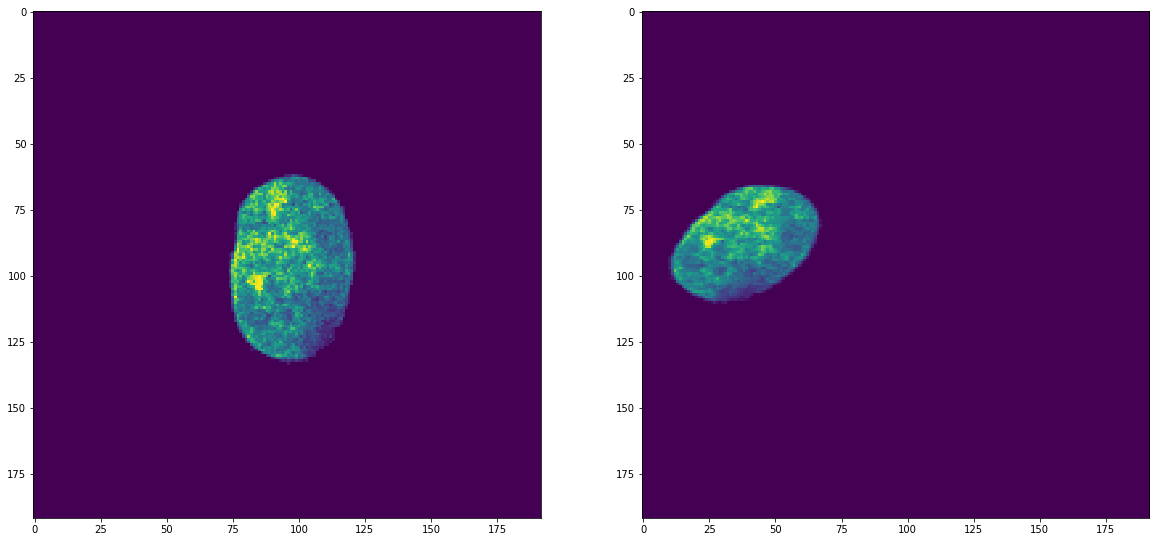

In [10]:
from skimage import transform as tf
box=192
tform =tf.AffineTransform(scale=(1,1.5), rotation=-0.5,translation=(0,0), shear=0)
img_warp = tf.warp(image, tform)

img_warp = img_warp*255
plt.subplots( figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(img_warp)
plt.show( )


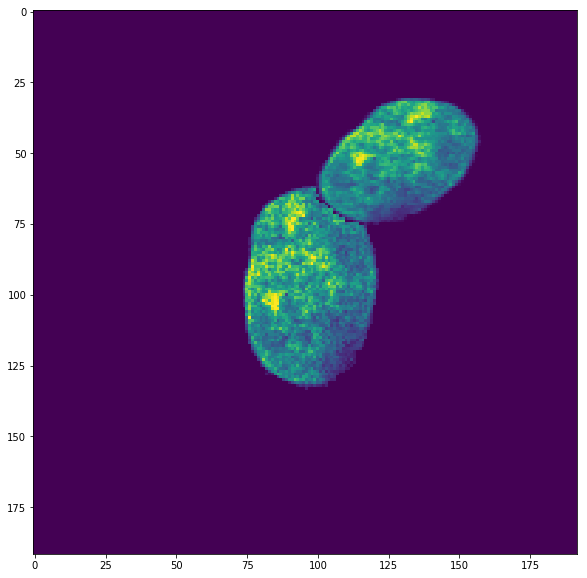

In [16]:

A = image
A_exp = np.zeros((192*3,192*3))
A_exp[192:192*2,192:192*2] = A
B = img_warp
#Cell A
t_li = A_exp > 0
label_image_blue = label(t_li)
cell=regionprops(label_image_blue, A_exp)[0]

A_contour=np.array(skimage.measure.find_contours(A_exp,0.5)[0], dtype="int")
A_contour = np.unique(A_contour, axis=0).tolist()
A_cen=cell.centroid
random_lim = A_contour[np.random.choice(range(len(A_contour)))]
#Cell B
t_li = B > 0
label_image_blue = label(t_li)
cell=regionprops(label_image_blue, B)[0]
B_rad = int(cell.equivalent_diameter*np.random.uniform(.8,1)/2)
B_coords=cell.coords.tolist()
B_cen_i=[int(cell.centroid[0]),int(cell.centroid[1])]

angle=np.angle(np.complex((random_lim[1]-A_cen[1]),(random_lim[0]-A_cen[0])))

B_cen=[int(random_lim[0]+(B_rad*np.sin(angle))),
       int(random_lim[1]+(B_rad*np.cos(angle)))]
B_in_A=[B_cen[0]-B_cen_i[0],B_cen[1]-B_cen_i[1]]

for i in B_coords:
    A_exp[B_in_A[0]+i[0],B_in_A[1]+i[1]]=B[i[0],i[1]]
A=A_exp[192:192*2,192:192*2]
plt.subplots( figsize=(10,10))

plt.imshow(A)
plt.show( )